In [103]:
from typing import List
from math import sqrt
import numpy as np
from scipy.sparse.linalg import norm
from scipy.constants import pi
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cirq
import openfermion as of
from kcommute import get_si_sets
from convert import to_groups_of

In [104]:
def bound(d, chi, zeta, gamma0p, h_norm, delta, deltap, big_deltap):
    if deltap > big_deltap:
        t0 = deltap
    else:
        t0 = 0.0
    t1 = chi / gamma0p
    c = 6.0 * h_norm / gamma0p
    p0 = chi / (deltap - delta)
    p1 = 8.0 * ((1.0 + (pi * delta) / (2.0 * h_norm)) ** (-2 * d))
    return t0 + t1 + c * (p0 + zeta + p1)

In [105]:
def first_order_comm_norm(
    groups: List[of.QubitOperator],
    nq: int
) -> float:
    """Norm of commutators from first-order Trotter bound in ToTECS Proposition 9.

    Arguments:
    groups: A list of qubit operators. Each represents a term in the Trotter expansion.

    Returns:
    Sum of commutator norms from Prop. 9."""

    # Evaluate sum_gamma1 ||[\sum_gamma2 H_gamma2, H_gamma1]||
    comm_norms = 0.0 # = sum_gamma1 ||\sum_gamma2 [H_gamma2, H_gamma1]||
    for i1 in range(len(groups)):
        total_commutator = of.QubitOperator() # = \sum_gamma2 [H_gamma2, H_gamma1]
        for i2 in range(i1 + 1, len(groups)):
            total_commutator += groups[i2] * groups[i1] - groups[i1] * groups[i2]
        tc_matrix = of.linalg.qubit_operator_sparse(total_commutator, nq)
        comm_norms += norm(tc_matrix, ord=2)
    return comm_norms


def s_dist_bound(d: int, tau: float, r: int, comm_norm: float) -> float:
    """Upper bound on ||S-S'|| from Trotter error.
    
    Arguments:
    d - subspace dimension.
    tau - evolution time
    r - number of time steps.
    comm_norm - sum of commutator norms.
    
    Returns:
    upper bound on ||S-S'||."""

    return d ** 2 * tau ** 2 / (sqrt(2.0) * r) * comm_norm

In [106]:
l = 2
t = 1.0
u = 2.0
ham_fermi = of.hamiltonians.fermi_hubbard(l, l, t, u, spinless=True)
ham = of.transforms.jordan_wigner(ham_fermi)
nq = of.utils.count_qubits(ham)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham)
groups = [[p] for p in ham_cirq]
groups_of = to_groups_of(groups)
comm_norm = first_order_comm_norm(groups_of, nq)
print(f"Commutator norm = {comm_norm}")
h_norm = norm(of.linalg.get_sparse_operator(ham))
print(f"h_norm = {h_norm}")

big_delta = 3.23
gamma0 = 0.99

tau = 0.1
d = 16
steps = range(10, 300)

s_distances = []
chis = []
bounds = []
for step in steps:
    s_distance = s_dist_bound(d, tau, step, comm_norm)
    s_distances.append(s_distance)
    chi = 2.0 * h_norm * s_distance
    chis.append(chi)
    eps = s_distance
    zeta = 2.0 * d * (eps + s_distance)
    # gamma0_p = gamma0 - 2 * eps - 2.0 * s_distance
    gamma0_p = gamma0
    # big_deltap = big_delta - chi / gamma0_p
    big_deltap = big_delta

    def bound_callback(v):
        """Evaluates bound for v=(delta, deltap)"""
        trial_bound = bound(d, chi, zeta, gamma0_p, h_norm, v[0], v[1], big_deltap)
        if trial_bound > 0:
            return trial_bound
        else:
            return -trial_bound * 1e15
    
    def delta_constraint(v):
        if big_deltap > 0.0:
            return big_deltap - v[1]
        else:
            return big_delta - v[1]

    # if big_deltap > 0:
    #     v0 = np.array([big_deltap / 2, big_deltap])
    # else:
    #     v0 = np.array([big_delta / 2, big_delta])
    v0 = np.array([big_delta, big_delta + chi / gamma0_p - 0.01])
    result = minimize(
        bound_callback, 
        v0,
        constraints=(
            {'type': 'ineq', 'fun': lambda v: v[1] - v[0] - chi / gamma0_p},
            {'type': 'ineq', 'fun': lambda v: v[0]},
            {'type': 'ineq', 'fun': lambda v: v[1]},
            {'type': 'ineq', 'fun': delta_constraint}
        ),
        method="COBYLA"
    )
    if not result.success:
        print(f"step = {step} did not succeed.")
    min_bound = result.fun
    # if min_bound < bound_callback(v0):
    #     bounds.append(min_bound)
    # else:
    #     bounds.append(bound_callback(v0))
    bounds.append(min_bound)

Commutator norm = 24.94427190999916
h_norm = 13.2664991614216
step = 10 did not succeed.
step = 11 did not succeed.
step = 12 did not succeed.
step = 13 did not succeed.
step = 14 did not succeed.
step = 15 did not succeed.
step = 16 did not succeed.
step = 17 did not succeed.
step = 18 did not succeed.
step = 19 did not succeed.
step = 20 did not succeed.
step = 21 did not succeed.
step = 22 did not succeed.
step = 23 did not succeed.
step = 24 did not succeed.
step = 25 did not succeed.
step = 26 did not succeed.
step = 27 did not succeed.
step = 28 did not succeed.
step = 29 did not succeed.
step = 30 did not succeed.
step = 31 did not succeed.
step = 32 did not succeed.
step = 33 did not succeed.
step = 34 did not succeed.
step = 35 did not succeed.
step = 36 did not succeed.
step = 37 did not succeed.
step = 38 did not succeed.
step = 39 did not succeed.
step = 40 did not succeed.
step = 41 did not succeed.
step = 42 did not succeed.
step = 43 did not succeed.
step = 44 did not su

In [107]:
print(np.min(bounds))
print(np.max(bounds))

2706.9369269115455
1.1882134122646422e+108


Text(0, 0.5, 'Energy bound')

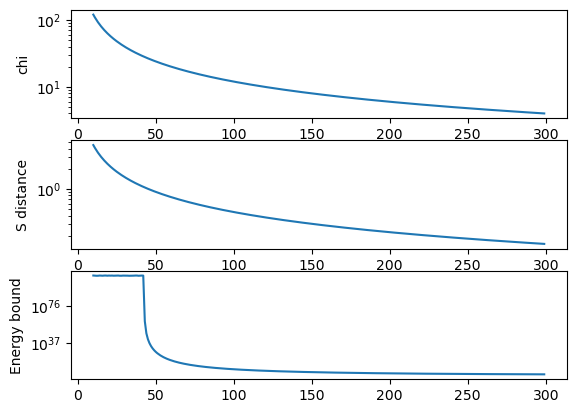

In [108]:
fig, axs = plt.subplots(3, 1)
for ax in axs:
    ax.set_yscale("log")
axs[0].plot(steps, chis)
axs[0].set_ylabel("chi")
axs[1].plot(steps, s_distances)
axs[1].set_ylabel("S distance")
axs[2].plot(steps, bounds)
axs[2].set_ylabel("Energy bound")